# Most basic example w/Embeddings
---
In this example we are just going to try a fairly simple FeedForward Neural Net. But this time with Embedding, we'll try and see if that changes the model and outcome as compared to the OneHot Features. We're going to go a bit extreme and actually change **every feature** to an embedding, including the *amount*. This may be a bit counter intuitive, but in some cases this yields better results, especially if there are a lot of missing values.

## Requirements
Before running the experiment, make sure to import the `numpy`, `pandas` and `numba`, `torch`, `tqdm`, `matplotlib`, `scikit-learn`, `captum` packages in your virtual environment
```
> pip install numpy
> pip install pandas
> pip install numba
> pip install torch
> pip install tqdm
> pip install matplotlib
> pip install scikit-learn
> pip install captum
```
And that the notebook can find the `f3atur3s`, `eng1n3` and `m0d3l` packages.

## Imports

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import f3atur3s as ft
import eng1n3.pandas as en
import m0d3l.pytorch as mp
import m0d3l.plot as mplt
import m0d3l.captum as cp

from captum.attr import IntegratedGradients

from typing import Tuple

/home/toms/Jupyter/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Set a random seed for Numpy and Torch
Will make sure we always sample in the same way. Makes it easier to compare results. At some point it should been removed to test the model stability.

In [2]:
# Numpy
np.random.seed(42)
# Torch
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
## Set up the devices, on from the data and one for modeling.
data_device  = torch.device('cpu')
model_device = torch.device('cuda') if torch.cuda.is_available() else data_device

## File Location
Change this to read from another location

In [4]:
file = '../../../../data/bs140513_032310.csv'

## Define Features
Most of the referential features have been set-up as a `FeatureIndex` which will make our models encode them as **Embeddings**.

The amount is set up as a `FeatureBin`, this is also a categorical feature and thus will be encoded as embedding by the model. We use a 'geometric' scale which spaces the amount out evenly over a log-scale, tends to be better in order to cancel out large outliers.


In [5]:
# Base Features
age = ft.FeatureSource('age', ft.FEATURE_TYPE_CATEGORICAL)
gender = ft.FeatureSource('gender', ft.FEATURE_TYPE_CATEGORICAL)
merchant = ft.FeatureSource('merchant', ft.FEATURE_TYPE_CATEGORICAL)
category = ft.FeatureSource('category', ft.FEATURE_TYPE_CATEGORICAL)
amount = ft.FeatureSource('amount', ft.FEATURE_TYPE_FLOAT)
fraud = ft.FeatureSource('fraud', ft.FEATURE_TYPE_INT_8)

# Categorical Features
amount_bin = ft.FeatureBin('amount_bin', ft.FEATURE_TYPE_INT_16, amount, 25, scale_type='geometric')
age_i = ft.FeatureIndex('age_index', ft.FEATURE_TYPE_INT_8, age)
gender_i = ft.FeatureIndex('gender_index', ft.FEATURE_TYPE_INT_8, gender)
merchant_i = ft.FeatureIndex('merchant_index', ft.FEATURE_TYPE_INT_16, merchant)
category_i = ft.FeatureIndex('category_index', ft.FEATURE_TYPE_INT_16, category)
# Label Feature
fraud_label = ft.FeatureLabelBinary('fraud_label', ft.FEATURE_TYPE_INT_8, fraud)

# TensorDefinitions
td_categorical = ft.TensorDefinition('categorical', [amount_bin, age_i, gender_i, merchant_i, category_i])
td_label       = ft.TensorDefinition('label', [fraud_label])

with en.EnginePandas() as e:
    ti = e.np_from_csv((td_categorical, td_label), file, inference=False)

print(ti.shapes)
print(ti.dtype_names)

2023-05-14 11:14:41.864 eng1n3.common.engine           INFO     Start Engine...
2023-05-14 11:14:41.864 eng1n3.pandas.pandasengine     INFO     Pandas Version : 1.5.3
2023-05-14 11:14:41.865 eng1n3.pandas.pandasengine     INFO     Numpy Version : 1.23.5
2023-05-14 11:14:41.866 eng1n3.pandas.pandasengine     INFO     Building Panda for : All_r_1 from file ../../../../data/bs140513_032310.csv
2023-05-14 11:14:42.134 eng1n3.pandas.pandasengine     INFO     Reshaping DataFrame to: All_r_1
2023-05-14 11:14:42.138 eng1n3.pandas.pandasengine     INFO     Converting All_r_1 to 2 numpy arrays


((594643, 5), (594643, 1))
('int16', 'int8')


## Create Data-Sets and Loaders

In [6]:
train, val, test = ti.split_sequential(30000, 100000)

batch_size = 128
# Creating DataSets
train_ds = mp.TensorInstanceNumpyDataSet(train)
val_ds   = mp.TensorInstanceNumpyDataSet(val)
test_ds  = mp.TensorInstanceNumpyDataSet(test)

# Creating an oversampler for the training set.
train_sampler = mp.TensorInstanceNumpyLabelSampler.over_sampler(train)

# Setting up the Dataloaders.
train_dl = train_ds.data_loader(data_device, batch_size, num_workers=2, sampler=train_sampler)
val_dl   = val_ds.data_loader(data_device, batch_size, num_workers=2)
test_dl  = test_ds.data_loader(data_device, batch_size, num_workers=2)

print(train.shapes)
print(val.shapes)
print(test.shapes)

((464643, 5), (464643, 1))
((30000, 5), (30000, 1))
((100000, 5), (100000, 1))


## Define a Model Class

In [7]:
class BankSimFeedForwardModel(mp.BinaryClassifier):
    def __init__(self, model_configuration: mp.ModelConfiguration):
        # Always call init, it is very important to correctly initialize the nn.Module
        super(BankSimFeedForwardModel, self).__init__(model_configuration)
        
        # Create the heads, they are the first layer of the NN.
        self.heads = self.create_heads(dim_ratio = 0.5, min_dims=5, max_dims=20, dropout=0.1)
        heads_size = sum([h.output_size for h in self.heads])
        
        # Set of layers
        self.layers = mp.LinLayer(input_size=heads_size, layer_sizes=(16, 8), dropout=0.0, bn_interval=2)
        
        # And a tail layer, for a binary classifier this is a Linear Layer + Sigmoid.
        self.tail = self.create_tail(self.layers.output_size)

    # Create a forward-pass function through the neural net. Make sure to return a Tuple of Tensors!
    def forward(self, x: Tuple[torch.Tensor, ...]) -> Tuple[torch.Tensor, ...]:
        o = torch.cat([h(x[i]) for i, h in enumerate(self.heads)], dim=1)
        o = self.layers(o)
        o = self.tail(o)
        return (o,)

#Create a model instance
model = BankSimFeedForwardModel(mp.ModelConfiguration.from_tensor_definitions(ti.target_tensor_def))
model

BankSimFeedForwardModel(
  Number of parameters : 2495. Loss : SingleLabelBCELoss,  mean
  (heads): ModuleList(
    (0): TensorDefinitionHead(
      Name=categorical, lc=Categorical
      (embedding): Embedding(
        (embeddings): ModuleList(
          (0): Embedding(25, 12)
          (1): Embedding(9, 5)
          (2): Embedding(5, 5)
          (3): Embedding(51, 20)
          (4): Embedding(16, 8)
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (layers): LinLayer(
    (layers): Sequential(
      (lin_layer_01): Linear(in_features=50, out_features=16, bias=True)
      (lin_act_01): ReLU()
      (lin_layer_02): Linear(in_features=16, out_features=8, bias=True)
      (lin_bn_02): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (lin_act_02): ReLU()
    )
  )
  (tail): Sequential(
    (tail_lin): Linear(in_features=8, out_features=1, bias=True)
    (tail_sig): Sigmoid()
  )
)

This is what the model would look like visually. (Some Layers were omitted for simplicity). And obviously the exact amount of neurons in the layers don't exactly match ...

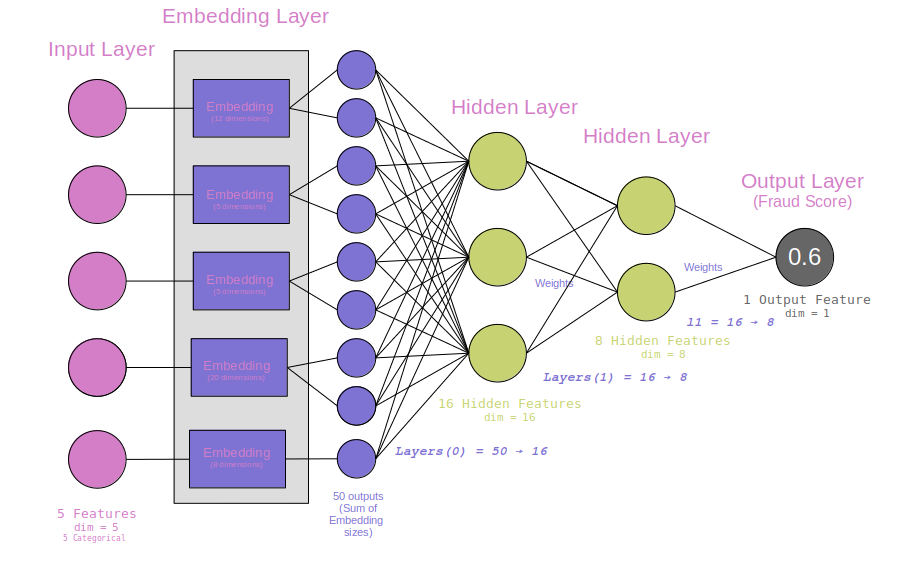

## Finding a Learning rate

Finding LR in 200 steps: 100%|██████████| 200/200 [00:00<00:00, 265.28it/s]                                                    


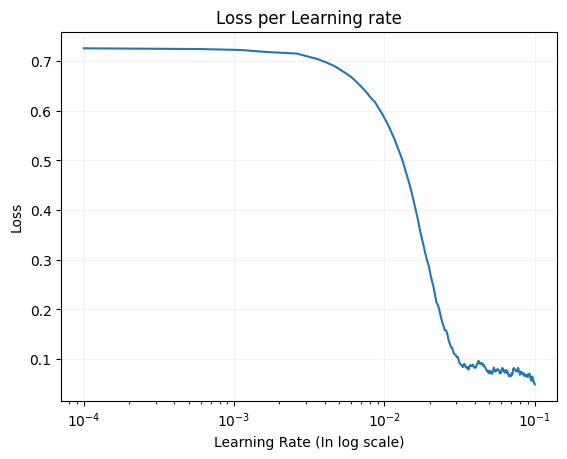

In [8]:
min_lr = 1e-4
max_lr = 1e-1
m_lr = BankSimFeedForwardModel(mp.ModelConfiguration.from_tensor_definitions(ti.target_tensor_def))
o_lr = mp.AdamWOptimizer(m_lr, lr=min_lr)
t_lr = mp.Trainer(m_lr, model_device, train_dl, val_dl)
lrs  = t_lr.find_lr(o_lr, max_lr, 200)
mplt.TrainPlot.plot_lr(lrs);

## Training
Run 5 epochs using a OneCycle LR scheduler

In [9]:
EPOCHS = 5

# First create a trainer.
trainer = mp.Trainer(model, model_device, train_dl, val_dl)
# Then an optimizer
optimizer = mp.AdamWOptimizer(model, lr=8e-3)
# Set up a OneCycle Scheduler
scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer=optimizer.optimizer, 
            max_lr=optimizer.lr,
            steps_per_epoch=trainer.number_of_train_steps,
            epochs=EPOCHS
)

# Run the trainer for [EPOCHS] epochs
history = trainer.train(EPOCHS, optimizer, scheduler)

Epoch 005/005: 100%|██████████| 3866/3866 [00:05<00:00, 754.30it/s, t_loss=0.0508, t_acc=0.98, v_loss=0.0355, v_acc=0.982]     


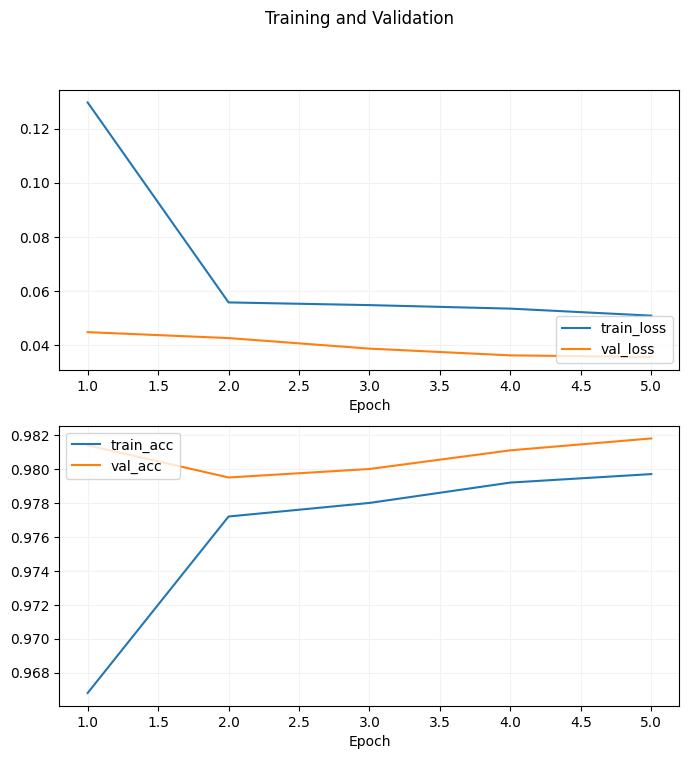

In [10]:
mplt.TrainPlot.plot_history(history, fig_size=(8,8));

## Testing the model

Testing in 782 steps: 100%|█████████████████| 782/782 [00:00<00:00, 1688.09it/s]


------------- Classification report -----------------
              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99     98926
         1.0       0.40      0.98      0.57      1074

    accuracy                           0.98    100000
   macro avg       0.70      0.98      0.78    100000
weighted avg       0.99      0.98      0.99    100000


auc score : 0.9987
ap score  : 0.9239
-----------------------------------------------------


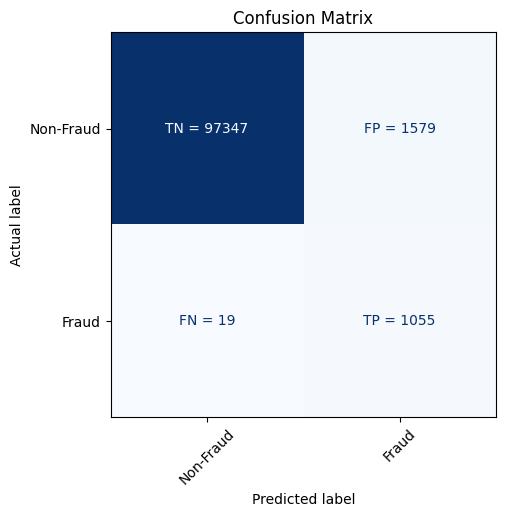

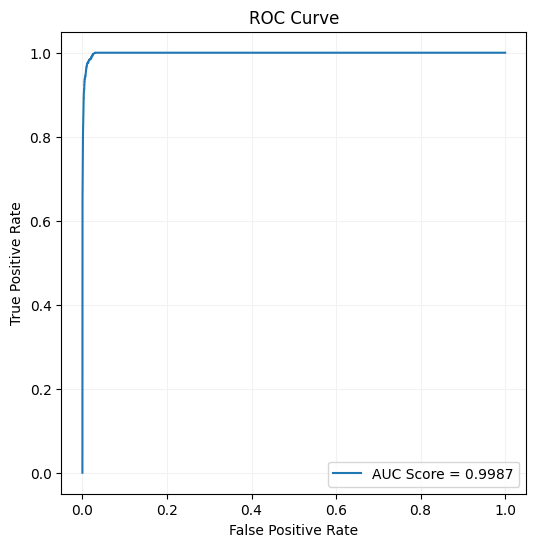

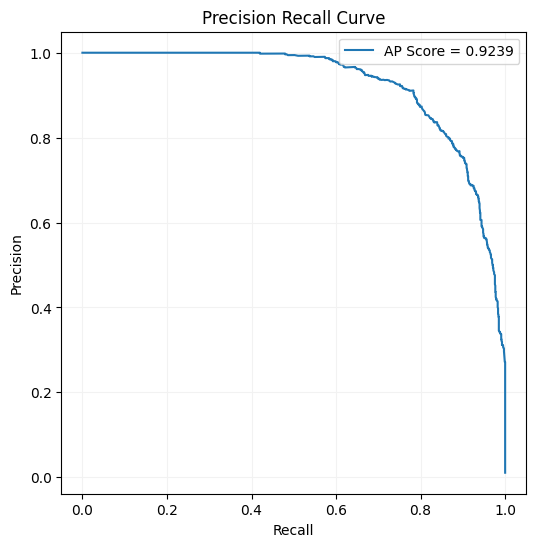

In [11]:
t = mp.Tester(model, model_device, test_dl)
results = t.test_results_binary()
mplt.TestPlot.print_binary_classification_report(results)
mplt.TestPlot.plot_binary_confusion_matrix(results, fig_size=(5,5));
mplt.TestPlot.plot_roc_curve(results, fig_size=(6,6));
mplt.TestPlot.plot_precision_recall_curve(results, fig_size=(6,6))

## Feature Deep Dive
We can have a look at the features.

In [12]:
attr = cp.CaptumAttributions.get_attributions_binary(
    model, ti.target_tensor_def, model_device, IntegratedGradients, test_ds[0:5000]
)

/home/toms/Jupyter/lib/python3.10/site-packages/captum/attr/_models/base.py:191: UserWarning: In order to make embedding layers more interpretable they will be replaced with an interpretable embedding layer which wraps the original embedding layer and takes word embedding vectors as inputs of the forward function. This allows us to generate baselines for word embeddings and compute attributions for each embedding dimension. The original embedding layer must be set back by calling `remove_interpretable_embedding_layer` function after model interpretation is finished. 
  warnings.warn(


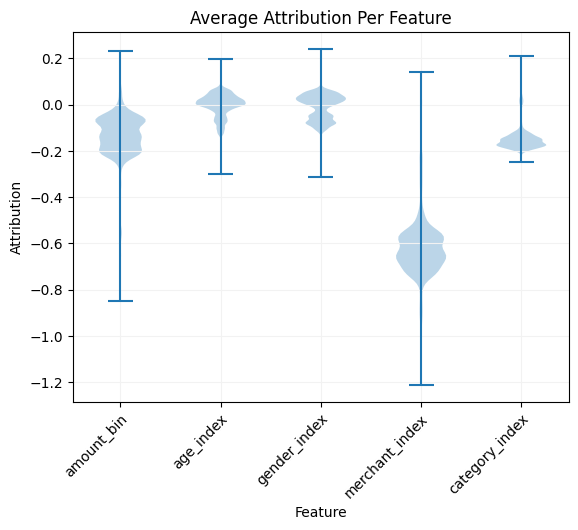

In [13]:
mplt.AttributionPlotBinary.overview(attr)

### Binned Amount

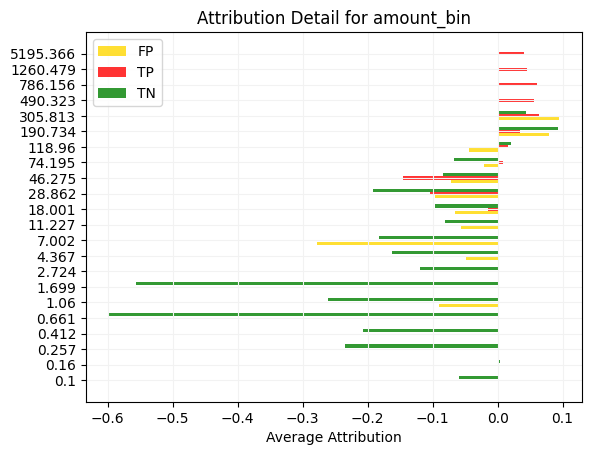

In [14]:
mplt.AttributionPlotBinary.feature_detail(attr, amount_bin)

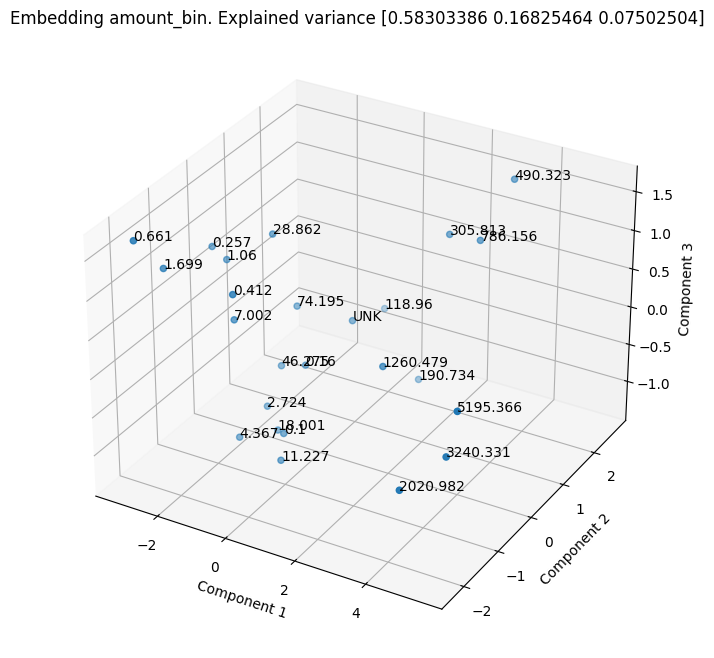

In [15]:
amount_weights = model.heads[0].embedding.embedding_weight(amount_bin).detach().cpu().numpy()
mplt.EmbeddingPlot.decompose_and_plot(amount_bin, amount_weights, dims=3, fig_size=(8,8))

### Age Index

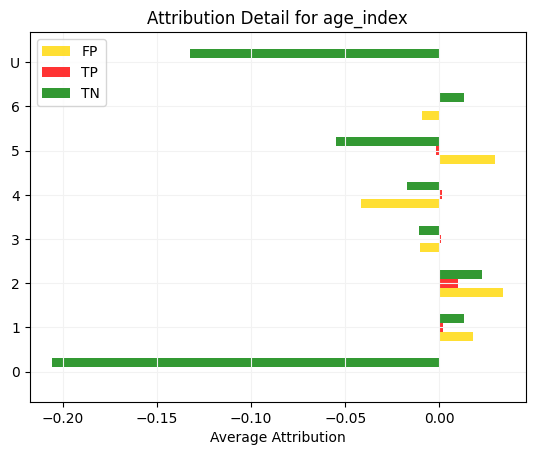

In [16]:
mplt.AttributionPlotBinary.feature_detail(attr, age_i)

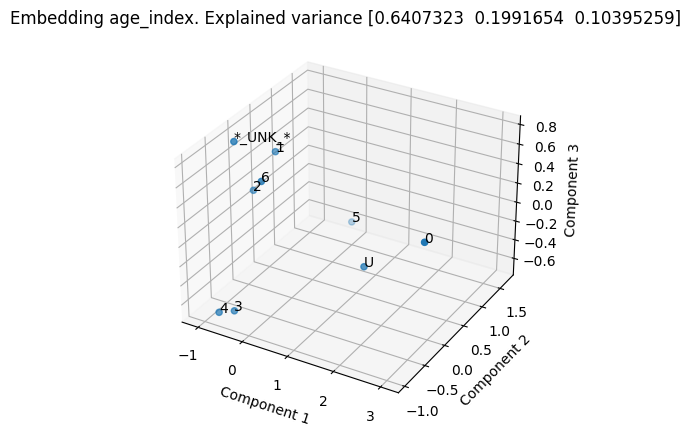

In [17]:
age_weights = model.heads[0].embedding.embedding_weight(age_i).detach().cpu().numpy()
mplt.EmbeddingPlot.decompose_and_plot(age_i, age_weights, dims=3, fig_size=(5,5))

### Gender Index

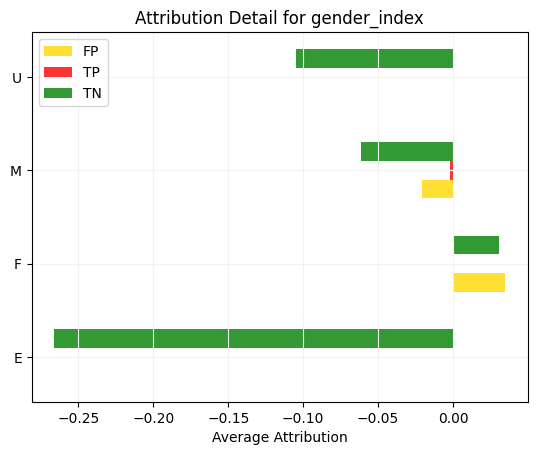

In [18]:
mplt.AttributionPlotBinary.feature_detail(attr, gender_i)

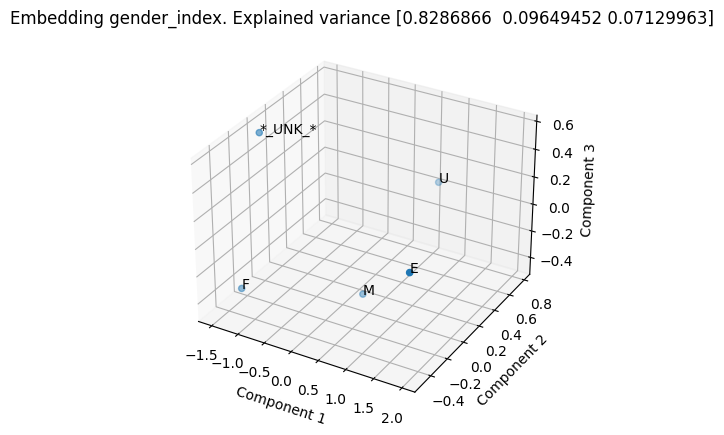

In [19]:
gender_weights = model.heads[0].embedding.embedding_weight(gender_i).detach().cpu().numpy()
mplt.EmbeddingPlot.decompose_and_plot(gender_i, gender_weights, dims=3, fig_size=(5,5))

### Merchant Index

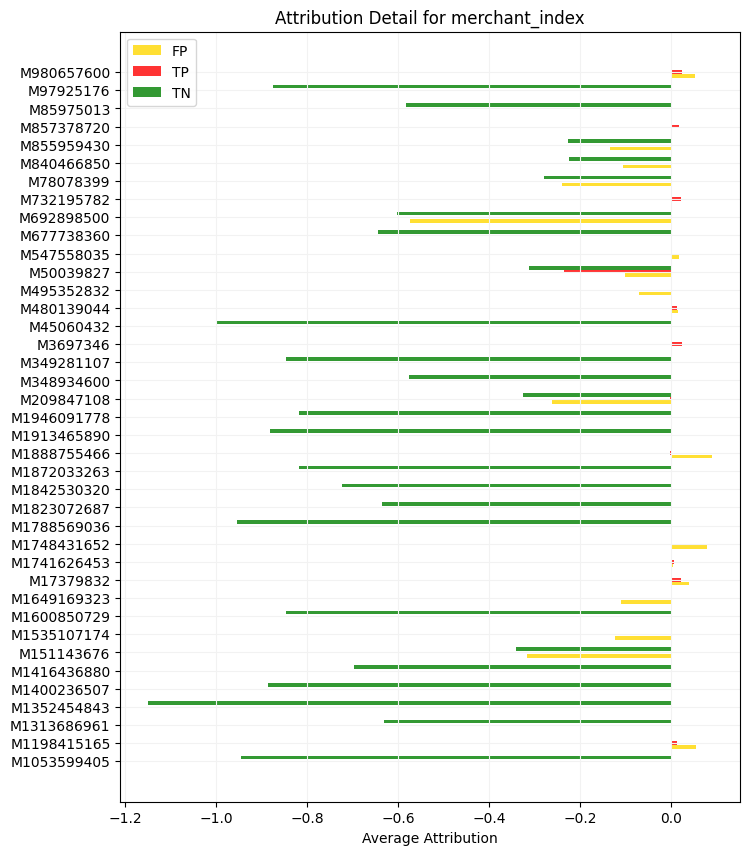

In [20]:
mplt.AttributionPlotBinary.feature_detail(attr, merchant_i, fig_size=(8,10))

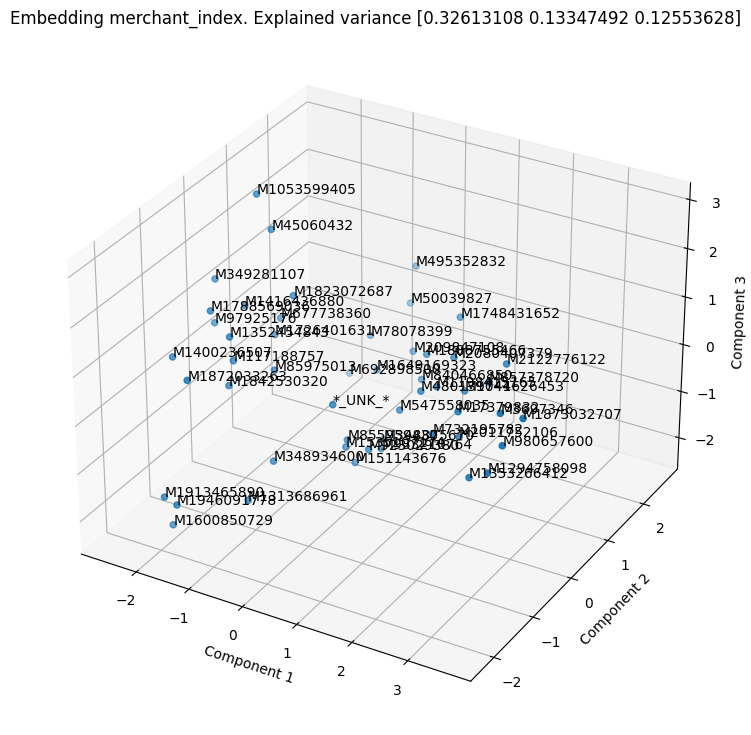

In [21]:
mer_weights = model.heads[0].embedding.embedding_weight(merchant_i).detach().cpu().numpy()
mplt.EmbeddingPlot.decompose_and_plot(merchant_i, mer_weights, dims=3, fig_size=(9,9))

### Category Index

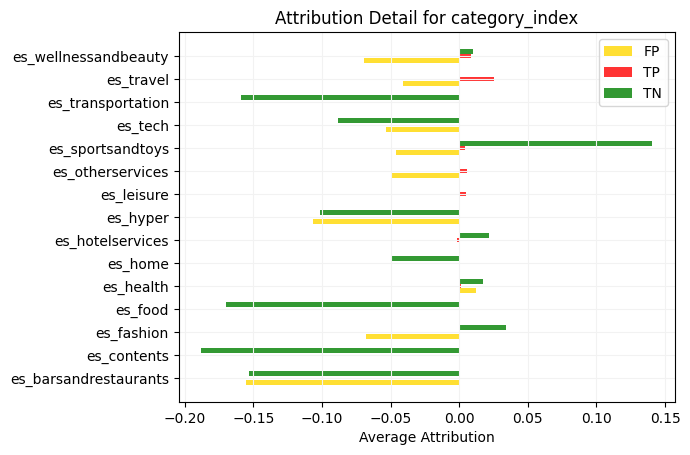

In [22]:
mplt.AttributionPlotBinary.feature_detail(attr, category_i)

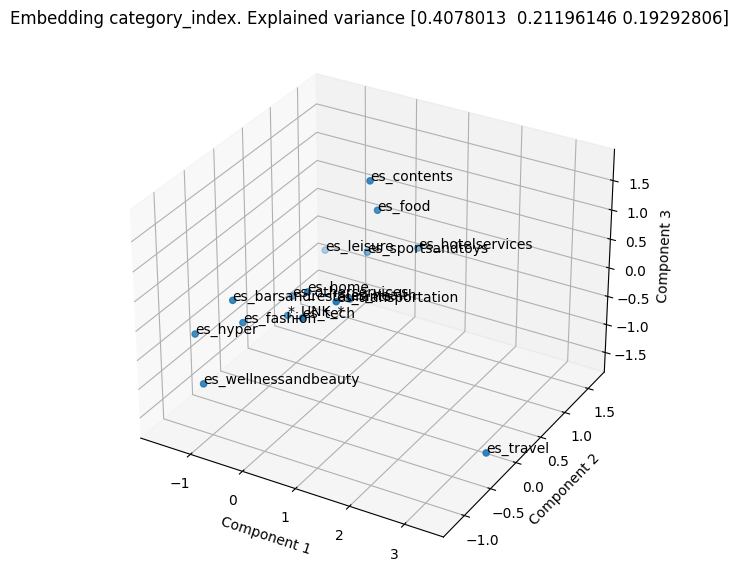

In [23]:
cat_weights = model.heads[0].embedding.embedding_weight(category_i).detach().cpu().numpy()
mplt.EmbeddingPlot.decompose_and_plot(category_i, cat_weights, dims=3, fig_size=(7,7))

Reduce the sample size a bit

In [24]:
attr = cp.CaptumAttributions.get_attributions_binary(
    model, ti.target_tensor_def, model_device, IntegratedGradients, test_ds[40:50]
)

/home/toms/Jupyter/lib/python3.10/site-packages/captum/attr/_models/base.py:191: UserWarning: In order to make embedding layers more interpretable they will be replaced with an interpretable embedding layer which wraps the original embedding layer and takes word embedding vectors as inputs of the forward function. This allows us to generate baselines for word embeddings and compute attributions for each embedding dimension. The original embedding layer must be set back by calling `remove_interpretable_embedding_layer` function after model interpretation is finished. 
  warnings.warn(


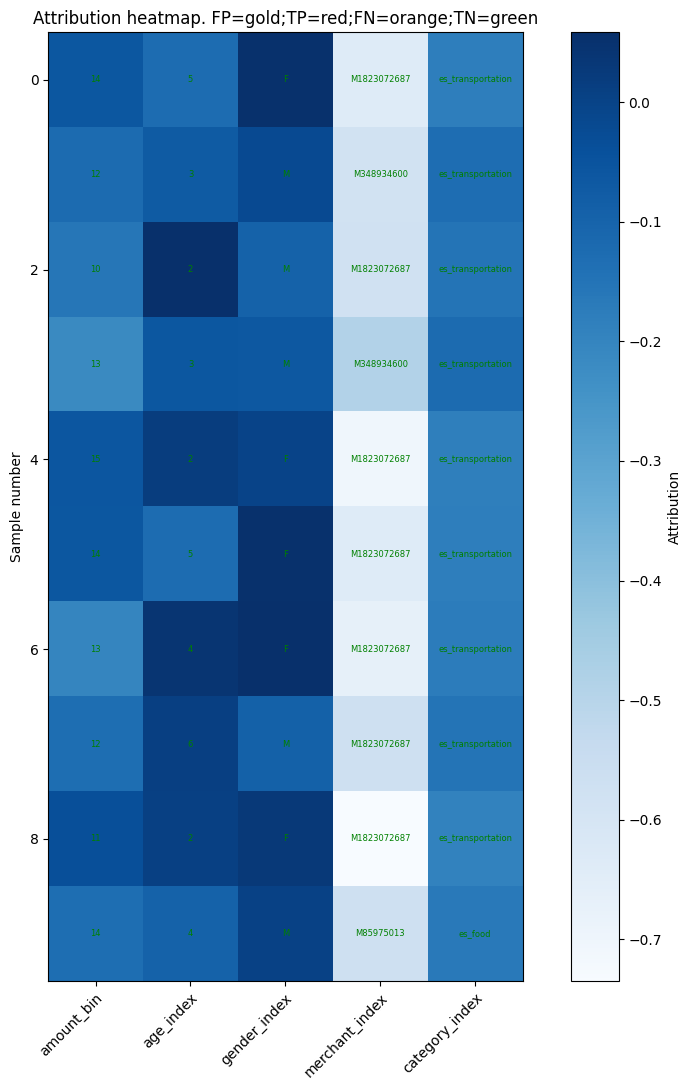

In [25]:
mplt.AttributionPlotBinary.heatmap(attr, td_categorical, fig_size=(10,11), font_size=6)

## Conclusion
This gives us a second example of the detection on a single record, this time with all embeddings. This model seems to do a bit better than the OneHot encoded example, but it's not fair to compare both, this Embeddings model has much more parameters.